In [2]:
! pip3 install matplotlib

In [3]:
import os
import sys
import torch 
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

In [4]:
path_to_package = os.path.abspath(os.path.join('..'))
if path_to_package not in sys.path:
    sys.path.append(path_to_package)
    
from src.utils.data_model_region import Region

In [6]:
# Global Constants
# Dataset
DATA_DIR_PATH = "./../data"
DATASET_PATH = f"{DATA_DIR_PATH}/PRSA2017_Data_20130301-20170228"
DATSET_PREPROCESSED_PATH = f"{DATA_DIR_PATH}/preprocessed"

# Model 
RANDOM_STATE = 1
PAST_WINDOW = 1
FUTURE_WINDOW = 1
BATCH_SIZE = 2048*16
TEST_SIZE = 0.4

DATE_COLUMNS = ['year','month','day','hour']
POLUTION_FEATURES = ["PM2.5","PM10","SO2","NO2","CO","O3"]



def get_preprocessed_dataset_path(region:Region, base_path:str=DATSET_PREPROCESSED_PATH)->str|None:
    """Get path to pre-processed dataset

    Args:
        region (Region): Specifies the region of the dataset
        base_path (str, optional): root dir of the dataset. Defaults to DATASET_PATH.

    Raises:
        ValueError: incorrect region provided

    Returns:
        str|None: returns the datset file path for the region or raises error
    """
    if type(region) == Region:
        return f"{base_path}/{region.value}.csv"
    else:
        raise ValueError("Unkown REGION name!!!")

In [8]:
regions_df = {}

for region in Region:
    # read datset
    regions_df[region] = pd.read_csv(get_preprocessed_dataset_path(region=region), index_col=None)
    # generate date
    regions_df[region]['date'] = pd.to_datetime(regions_df[region][DATE_COLUMNS])
    regions_df[region].drop(DATE_COLUMNS, axis=1, inplace=True)
    # regions_df[region].drop('hour', axis=1, inplace=True)
    # # group by daily and average
    # regions_df[region] = regions_df[region].groupby('date').mean()
    # set datetime index 
    regions_df[region] = regions_df[region].set_index('date')

del region

In [9]:
# display sample
regions_df[Region.AOTIZHONGXIN]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,N,S,E,W
date,,,,,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,1.0,0.0,0.0,1.0
2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,1.0,0.0,0.0,0.0
2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,1.0,0.0,0.0,1.0
2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,1.0,0.0,0.0,1.0
2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,2.4,1.0,0.0,0.0,1.0
2017-02-28 20:00:00,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,0.9,1.0,0.0,0.0,1.0
2017-02-28 21:00:00,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,1.1,1.0,0.0,0.0,1.0


<Axes: xlabel='date'>

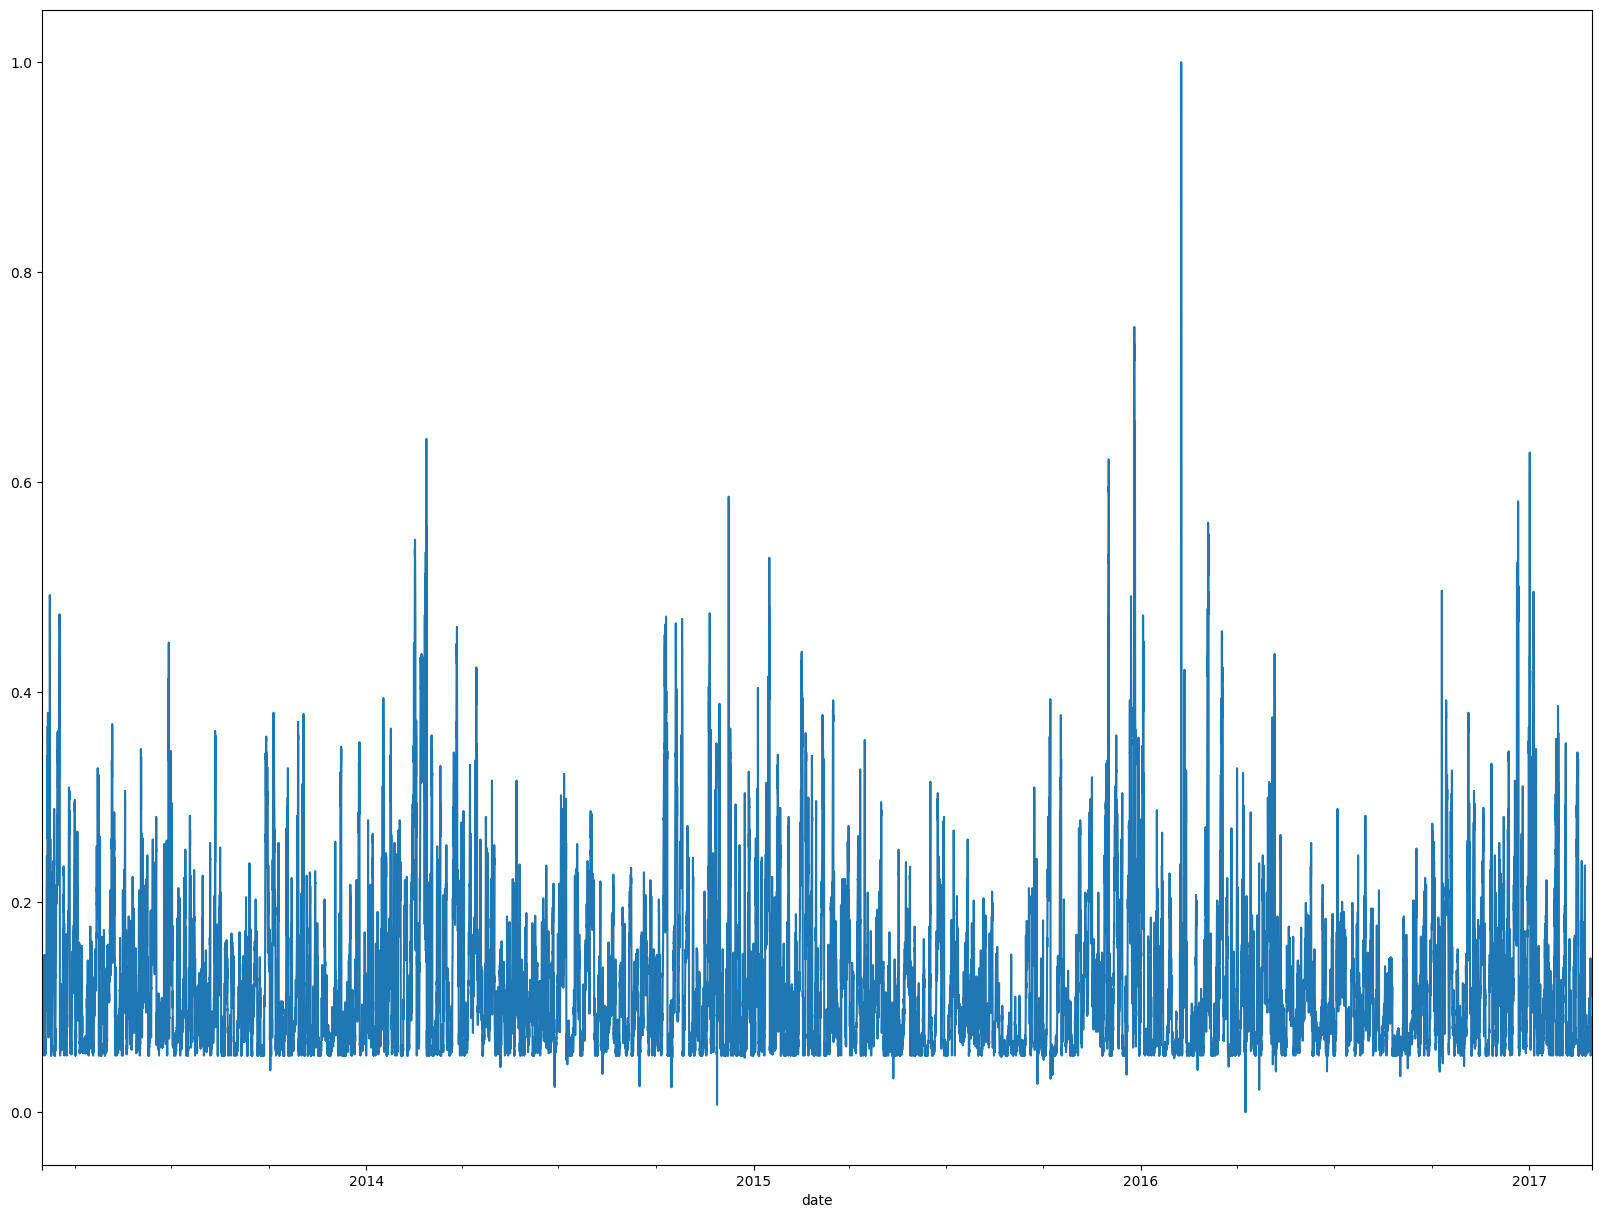

In [20]:
standardised_df = (regions_df[Region.DINGLING] - regions_df[Region.DINGLING].min()) / (regions_df[Region.DINGLING].max() - regions_df[Region.DINGLING].min())
standardised_df['PM2.5'].plot(figsize=(20,15))